In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sqlalchemy.orm import Session
from datetime import datetime
from database.database import get_db
from database.models import Project, Bandit, Experiment


In [2]:
TAU = 1.0

In [3]:
def create_project(description, prices, db):
    """
    Create a project with bandits defined by prices.
    """
    project = Project(description=description, number_bandits=len(prices))
    db.add(project)
    db.commit()
    db.refresh(project)
    for p in prices:
        b = Bandit(project_id=project.project_id, price=p, mean=0.0, variance=1.0, reward=0.0, trial=0)
        db.add(b)
    db.commit()
    return project


In [4]:
def get_champion_bandit(project_id, db):
    """
    Sample each bandit from N(mean, 1/sqrt(λ)),
    and return the bandit with highest sample.
    """
    bandits = db.query(Bandit).filter(Bandit.project_id == project_id).all()
    samples = []
    for b in bandits:
        mean = float(b.mean)
        lambda_ = float(b.variance)
        std = 1.0 / np.sqrt(lambda_)
        samples.append(np.random.normal(mean, std))
    best_idx = np.argmax(samples)
    return bandits[best_idx]


In [5]:
def submit_reward(bandit_id, reward_value, decision, db: Session):
    """
    Gaussian posterior update:
        λ_new = λ + τ
        sum_x_new = sum_x + reward
        mean_new = (τ * sum_x_new) / λ_new

    """

    b = db.query(Bandit).filter(Bandit.bandit_id == bandit_id).first()
    reward = float(reward_value)

    experiment = Experiment(
        project_id=b.project_id,
        bandit_id=b.bandit_id,
        decision=decision,
        reward=reward,
        start_date=datetime.now(),
        end_date=datetime.now()
    )
    db.add(experiment)

    lam_old = float(b.variance)
    sum_x_old = float(b.reward)

    lam_new = lam_old + TAU
    sum_x_new = sum_x_old + reward
    mean_new = (TAU * sum_x_new) / lam_new

    b.variance = lam_new
    b.reward = sum_x_new
    b.mean = mean_new
    b.trial += 1
    b.updated_at = datetime.now()

    db.commit()
    db.refresh(b)
    return b


In [6]:
def plot_bandit_distributions(bandits, title="Posterior Distributions"):
    """
    Plots each Gaussian posterior with clear labels.
    """
    plt.figure(figsize=(12, 6))

    means = [float(b.mean) for b in bandits]
    stds = [1 / np.sqrt(float(b.variance)) for b in bandits]

    xmin = min(means) - 4 * max(stds)
    xmax = max(means) + 4 * max(stds)

    x = np.linspace(xmin, xmax, 400)

    for b in bandits:
        mean = float(b.mean)
        lam = float(b.variance)
        std = 1 / np.sqrt(lam)
        y = norm.pdf(x, mean, std)

        label = (
            f"Price={float(b.price):.2f} | "
            f"Mean={mean:.2f} | "
            f"Var={1/lam:.2f} | "
            f"Trials={b.trial}"
        )

        plt.plot(x, y, linewidth=2, label=label)

    plt.title(title)
    plt.xlabel("Reward")
    plt.ylabel("Density")
    plt.legend(fontsize=11)
    plt.grid(True)
    plt.show()


In [7]:
def run_trials(project_id, n_trials, db: Session):
    """
    Runs Gaussian Thompson Sampling simulation for n_trials steps.
    """
    for _ in range(n_trials):
        bandit = get_champion_bandit(project_id, db)

        reward = float(bandit.price)

        submit_reward(
            bandit_id=bandit.bandit_id,
            reward_value=reward,
            decision="simulated",
            db=db
        )


In [ ]:
def plot_after_n_trials(project_id, n_trials, db: Session):
    run_trials(project_id, n_trials, db)
    bandits = db.query(Bandit).filter(Bandit.project_id == project_id).all()
    total_trials = sum(b.trial for b in bandits)
    plot_bandit_distributions(bandits, f"Posterior After {total_trials} Trials")


In [9]:
# Test
db = next(get_db())

In [10]:
project = create_project("Gaussian Test", [1,2,3], db)

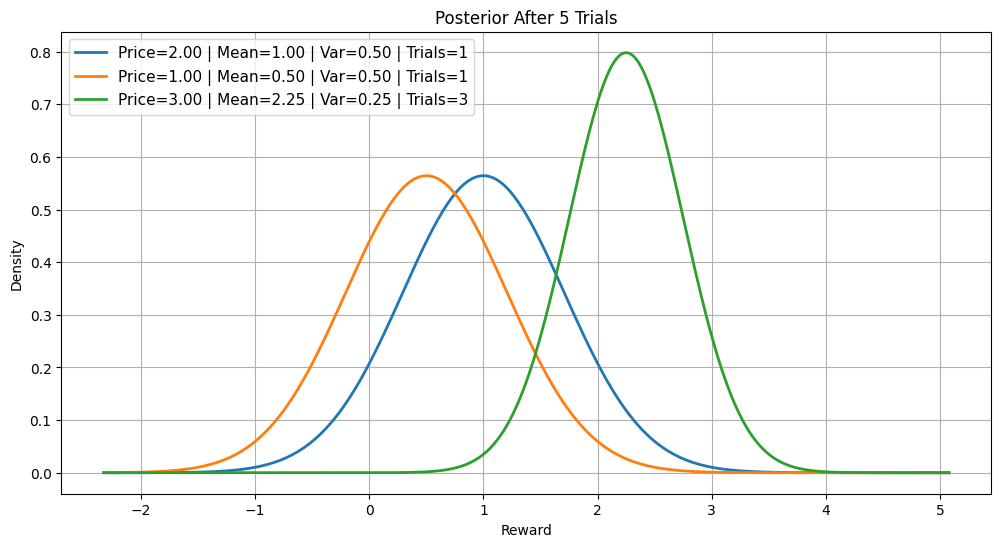

In [11]:
# Plot after 5 trials
plot_after_n_trials(project.project_id, 5, db)


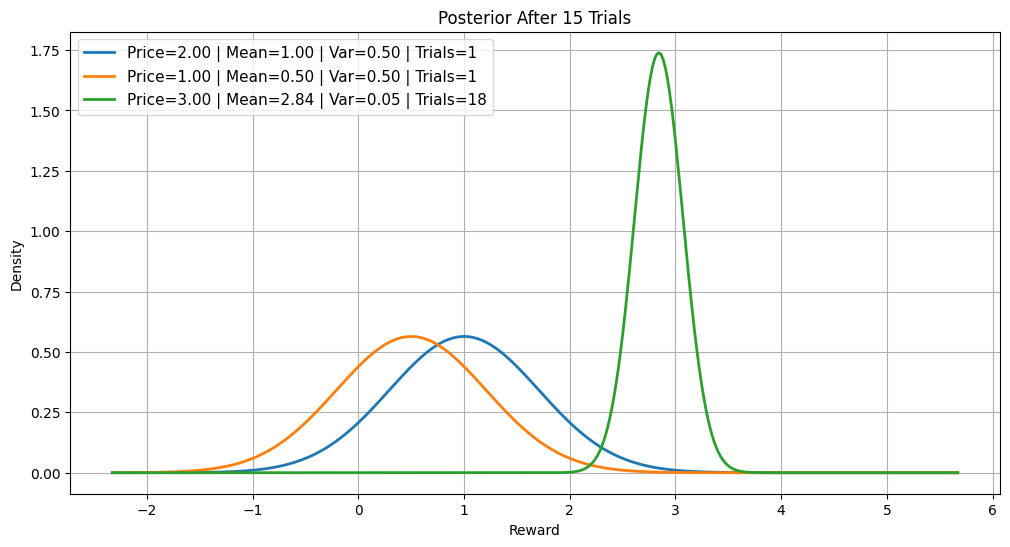

In [12]:
# Plot after 15 trials
plot_after_n_trials(project.project_id, 15, db)

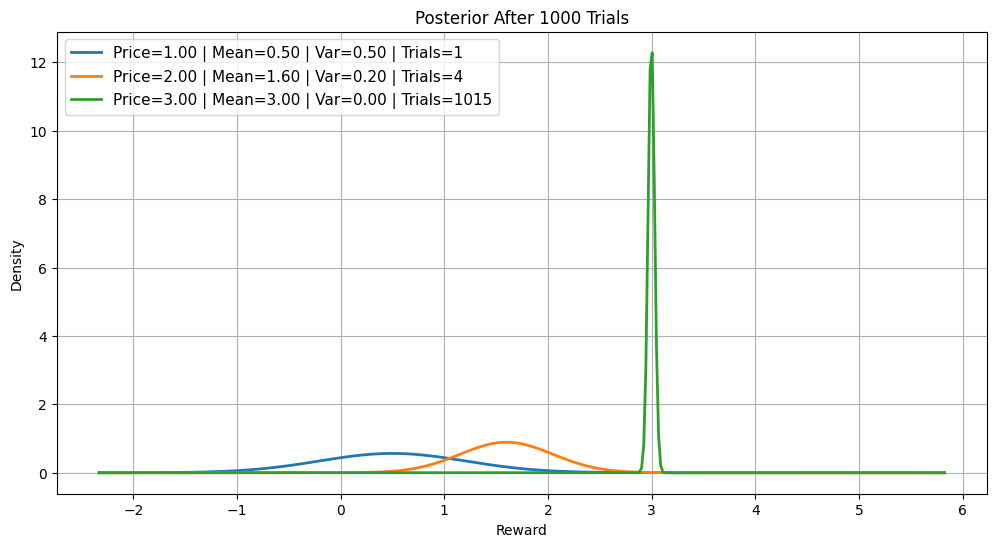

In [ ]:
# Plot after 1000 trials
plot_after_n_trials(project.project_id, 1000, db)